## Collect all fonts and apply filters

### Modules and pathes

In [26]:
import sys
sys.path.append('../')

In [27]:
# forcing the notebook to reload the modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from src.data import downloader as dl
from src.data import datacollector as dc
from src.data import datafilter as df
from src.data import fontdb_handler as fh
from src.data import classifier as cl
from src.data import global_consts as g

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### Downloading the fonts

#### Fonts from github archives

In [4]:
# Download files from Databases
GOOGLEFONTSDB = False
DSRFONTSDB = True

dl.get_font_dbs({'GoogleFontsDB' : GOOGLEFONTSDB,
              'DSRFontsDB' : DSRFONTSDB})

Accessing DSRFontsDB.
Loaded key for repository access.
5 directories for transfer.
Transferring files...
File transfer successful


#### Fonts from list(s) of URLs

In [6]:
LINKLISTS = False
# Process link lists, starting with glyphazzn
dl.update_glyphazzn_list()

if LINKLISTS:
    # Start download. This will take a while! (approx 80 mins for glyphazzn)
    dl.download_files_from_txts()

glyzphazzn link list updated.
glyphazzn_raw.txt successfully extracted.


### Processing all fonts

1. All zipped archives are getting unpacked. Through recursion, zip-in-zip are getting unpacked.
2. From data exploration we know that we will have fonts in different format: TTF, OTF and PFB.
3. We externally converted *.OFT to *.TTF. The converted files were copied into our private font database, hence our script will ignore *.OTF

To avoid copying files to a 'processed' folder, we will create a 00dataset.json file that we will use from now on. We will gradually fill the json with information.

In [28]:
dc.collectfonts()

Unpacking all zip files...
Total files: 62541
Fonts files: 51826
- TTF files: 41532
- OTF files: 10294
Usable files: 51826


## Filtering fonts

Finally, the filters are applied to the dataset. The filters will write a value to the json file for each font and set a general flag indicating whether the font is usable or not.

In [29]:
df.filter_fonts()

29it [00:00, 86.93it/s]'created' timestamp seems very low; regarding as unix timestamp
290it [00:01, 234.58it/s]'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
395it [00:02, 233.97it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
516it [00:02, 279.87it/s]'created' timestamp seems very low; regarding as unix timestamp
545it [00:02, 234.57it/s]'created' timestamp seems very low; regarding as unix timestamp
649it [00:03, 235.19it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
1265it [00:05, 268.05it/s]'created' timestamp seems very low; regarding as unix timestamp
1479it [00:06, 236.89it/s]'created' timestamp out of rang

OverflowError: Python int too large to convert to C int


1597it [00:06, 184.28it/s]'created' timestamp out of range; ignoring top bytes
'modified' timestamp out of range; ignoring top bytes
'created' timestamp out of range; ignoring top bytes
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp out of range; ignoring top bytes
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
1625it [00:07, 208.03it/s]'created' timestamp seems very low; regarding as unix timestamp
'created' timestamp out of range; ignoring top bytes
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp out of range; ignoring top bytes
'modified' timestamp seems very low; regarding as unix timestamp
1654it [00:07, 228.96it/s]'created' timestamp out of range; ignoring top bytes
1748it [00:07, 248.81it/s]'created' timestamp seems very low; regarding as unix timestamp
1843it [00:07, 250.80it/s]'created' timestamp seems very low; regarding 

Processed 51826 fonts. Found 26890 usable fonts.


{'num_font_files_processed': 51826,
 'num_usable_fonts': 26890,
 'out_of_bounds': 10615,
 'has_empty_glyphs': 14656,
 'has_not_all_chars': 10899,
 'corrupted_file': 105}

Some fontsets have invalid glyps. We need to identify them and remove them from the dataset.
We are using CLIP to do so.

100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


{'..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\24Janvier-Light.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\24Janvier.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\AgenorNeue-Regular.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Alido.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\allejo.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\almonte.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Always Together.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Ancillary-Bold.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Ancillary-BoldItalic.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Ancillary-Italic.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Ancillary-Regular.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Angelika-Playfull.otf': {'ß': True},
 '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\ANVYL.otf': {'ß'

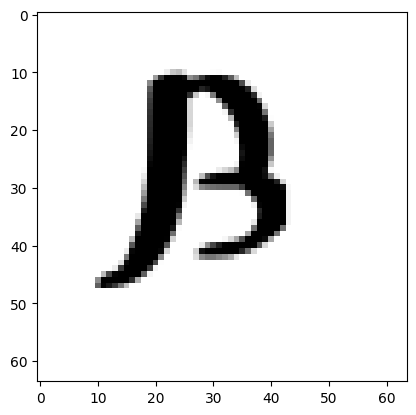

In [80]:
from src.data import datarenderer
import matplotlib.pyplot as plt


text_query = ['letter ß', 'letters ss', 'an X', 'one-colored box', 'rectangle', 'not letter ß']
test_fonts_paths =['../data/raw/DSRFontsDB/DB1/fonts_otf/24Janvier-Light.otf', '../data/raw/DSRFontsDB/DB1/fonts_otf/AUSTRALIA-TITLE.otf']
path_to_valid_fonts = fh.font_file_list()


test_fonts_paths = path_to_valid_fonts[0:20]

img_arrays_test = datarenderer.render_fonts(test_fonts_paths, chars='ß')
plt.imshow(img_arrays_test[1,:,:, 0], cmap='gray')
cl.evaluate_image(test_fonts_paths, 'ß', verbose=False)


In [30]:
path_to_valid_fonts = fh.font_file_list()

CLIP_result = cl.evaluate_image(path_to_valid_fonts, 'ß')

fh.write_filter_results(CLIP_result)
    

Rendering images...
path: ['..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\24Janvier-Light.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\24Janvier.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\AgenorNeue-Regular.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Alido.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\allejo.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\almonte.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Always Together.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Ancillary-Bold.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Ancillary-BoldItalic.otf', '..\\data\\raw\\DSRFontsDB\\DB1\\fonts_otf\\Ancillary-Italic.otf']


100%|██████████| 1681/1681 [2:37:27<00:00,  5.62s/it]  


In [31]:
# Store result of clip filter in seperate json file
import json
import os

path_clip = os.path.join(g.PATH_RAW, 'clip.json')
with open(path_clip, 'w', encoding='utf-8') as jsonfile:
    json.dump(CLIP_result, jsonfile, indent=4)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [83]:
# Store result of clip filter in seperate json file
with open(path_clip, 'w', encoding='utf-8') as jsonfile:
    json.dump(CLIP_result, jsonfile, indent=4)

In [32]:
with open(path_clip, 'r', encoding='utf-8') as jsonfile:
    data_check = json.load(jsonfile)

count_true = 0
count_false = 0

for key, value in data_check.items():
    if data_check[key]['ß'] == True:
        count_true += 1
    else:
        count_false += 1
        
print(count_true)
print(count_false)

21326
5564
